# Cooke triplet optimization

I'm going to try and come up with a better "user interface" for optimization, based on the "textbook" Cooke triplet example from this page:

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

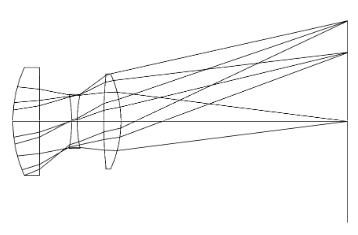

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

import opticsRayTrace.rayTraceTools_numba as rtt
import opticsRayTrace.drawing as rtd
import opticsRayTrace.optimize as rto

I'm going to try identifying the variables, within the surface list, for readability. Then the optimization process can automate bundling the list of variables into a 1-d numeric array for the minimize() function.

In [2]:
surface_list = [
{'surf': 'dummy',
 'dist': 10},

{'surf': 'conic',
  'R': 23.713,
  'dist': 4.831,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': 7331.288,
  'dist': 5.86,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': -24.456,
  'dist': 0.975,
  'draw_radius': 10,
  'material': 'N-SF5',
  'stop': True,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 21.896,
  'dist': 4.822,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 86.759,
  'dist': 3.127,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': -20.494,
  'dist': 41.10346,
  'draw_radius': 10,
  'variables': ['R']},
  
 {'surf': 'dummy'}
 ]

stop_surface = 4

Prior to optimization, I'll take care of some housekeeping, such as documenting the starting point, ray aiming, and finding convenient diameters for drawing.

In [3]:
geometry = rtt.build_geometry(surface_list)

# Lists of field anles, pupil heights, and (for now) zero pupil shifts

field_angles = np.linspace(0, 15, 5)
pupil_radii = np.linspace(-4, 4, 7)

# turn those lists into rays

field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in field_angles])
pupil_points = np.array([np.array([x, 0, 0]) for x in pupil_radii])
wavls = np.array([0.000633])

# my usual ray tracing steps

infinite = True
aim_consts = np.zeros([6], dtype = float)
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite, aim_consts)
t0 = time.time()
rtt.trace_rays(ray_table, geometry)
print(time.time() - t0)

# now let's see what we've got

axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point before ray aiming")
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'intersect_line_plane_numba':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "..\src\opticsRayTrace\rayTraceTools_numba.py", line 403:[0m
[1mdef compute_sags_conic_surface(ray_table, surf, origin, z_axis, c, k, r, sag):
    <source elided>
        for iter in range(40):
[1m            intersect_line_plane_numba(
[0m            [1m^[0m[0m
[0m

The apparent entrance pupil is at the entrance to the system, not where we want it. Now I need to choose values for the pupil shifts. I will say that the rays are correctly "aimed" when the ray bundle for each field angle is centered at the stop surface, i.e., that the squared position of those rays is at a minimum. This suggests a merit function and optimization.

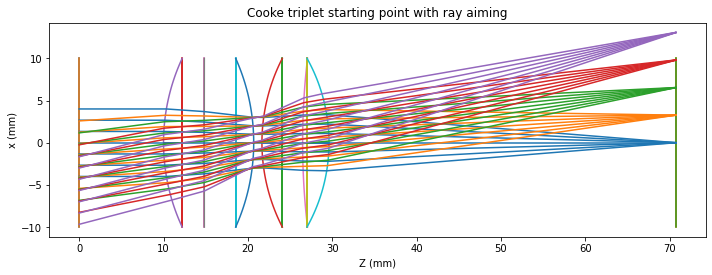

In [4]:
'''
The ray aiming constants are 6 coefficients of a linear transformation applied
to field points. Ray aiming finds values of these coefficients that minimize the
RMS radius of the ray bundle at the stop surface.
'''
aim_consts = rto.ray_aiming(geometry, wavls, True)

'''
Given desired values of the aiming constants, we recompute the starting ray table
and propagate the new rays through the optical system. Note that I haven't
optimized the design yet, but the spot sizes already look smaller. This design
is now closer to the original textbook design.
'''
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             aim_consts = aim_consts)
rtt.trace_rays(ray_table, geometry)
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = 'field')
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming")
plt.show()

One last trimming: I didn't give any radii for drawing the surfaces, and it's hard to visually compare the drawings to the one from the reference, so I created a little script that applies a default to each surface, just big enough to contain the rays, plus a margin. This is purely aesthetic. My program doesn't do anything with the draw radius while ray tracing.

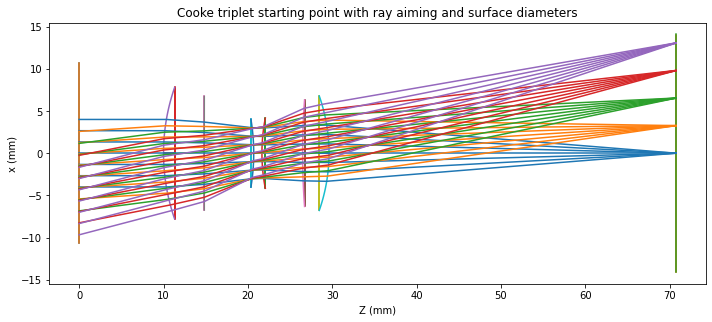

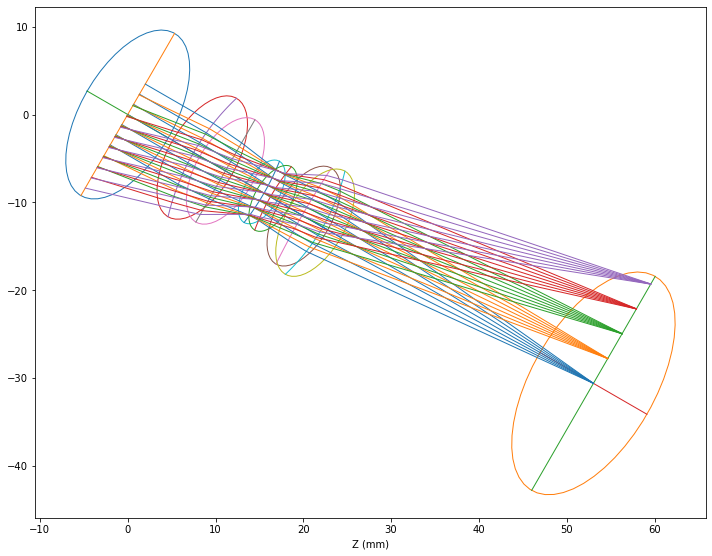

In [5]:
def find_draw_radii(ray_table):
    radius_list = []
    for surf in range(ray_table.shape[0]):
        radius = np.max(np.sqrt(np.sum(ray_table[surf, :, 0, :-1]**2, axis = 1)))
        radius_list.append(radius)
    return np.array(radius_list)

def apply_draw_radii(geometry, ray_table, margin):
    radii = find_draw_radii(ray_table) + margin
    for i in range(len(geometry)):
        geometry[i]['draw_radius'] = radii[i]
        
apply_draw_radii(geometry, ray_table, 1)
        
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming and surface diameters")
plt.show()
axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
plt.show()

I'm going to define a really basic merit function, which will be the sum of RMS spot sizes. For this purpose, the rays have to be separated by field, so that each field gets its own RMS value.

In [6]:
def rms_by_field(ray_table):
    '''
    Compute RMS spot size as a function of field number for X ad Y
    '''
    
    rayx = ray_table[-1, :, 0, 0]
    rayy = ray_table[-1, :, 0, 1]
    rayfields = ray_table[-1, :, 3, 0].astype(int)
    return np.array([[np.std(rayx[rayfields == f]), np.std(rayy[rayfields == f])] 
                     for f in np.arange(np.max(rayfields) + 1)])

rms_by_field(ray_table)

array([[4.23669026e-03, 8.55866972e-10],
       [4.51358622e-03, 1.54491085e-08],
       [5.38700204e-03, 2.41519159e-08],
       [6.69160730e-03, 1.85109612e-08],
       [6.93042924e-03, 1.83977029e-08]])

Now I'm going to experiment with automating the extraction of variables and generating a merit function.

In [7]:
def get_variables(surface_list):
    result = []
    for surface, n in zip(surface_list, range(len(surface_list))):
        if 'variables' in surface:
            for v in surface['variables']:
                result.append([n, v])
    return result

variables = get_variables(surface_list)
variables

[[1, 'R'], [2, 'R'], [3, 'R'], [4, 'R'], [5, 'R'], [6, 'R']]

In [8]:
def get_starting_points(surface_list, variables):
    result = []
    for v in variables:
        result.append(surface_list[v[0]][v[1]])
    return np.array(result)

starting_points = get_starting_points(surface_list, variables)
starting_points

array([  23.713, 7331.288,  -24.456,   21.896,   86.759,  -20.494])

This cell builds the merit function by populating the variables and then tracing the rays. Since my variables don't include any distances or coordinate transformations, I don't strictly need the build_geometry() function, but it's also not very costly.

Notice that the parameters are all multiplicative factors, meaning that they all start out at 1. This is equivalent to "normalizing" coefficients in machine learning exercises. I decided to try it here because it seems to make fitting more stable. For instance, calling minimize() without specifying a method fails without normalization, and succeeds with normalization.

In [9]:
def merit(p):
    global opt_geometry
    for v, i in zip(variables, range(len(variables))):
        surface_list[v[0]][v[1]] = p[i]*starting_points[i]
    opt_geometry = rtt.build_geometry(surface_list)
    rtt.trace_rays(ray_table, opt_geometry)
    return np.sum(rms_by_field(ray_table)**2)

merit_before = merit(np.ones_like(starting_points))
merit_before

0.0001601502537057403

Finally, I'm just going to naievely throw the merit function into the minimize() process without any special settings, and see what happens. I've found that when the optimization fails, choosing **method = 'Nelder-Mead'** makes it more stable. That's what we used to call the Simplex algorithm. We don't need sophisticated optimization here, just something that works. For one thing, all of the best parameters will be subject to manufacturing tolerances in the real world.

In [10]:
t0 = time.time()
result = minimize(merit, np.ones_like(starting_points))
print(time.time() - t0)

20.239529132843018


In [11]:
result

      fun: 5.557777726875071e-06
 hess_inv: array([[ 3.06894041e+02,  1.03775553e+02, -5.18433833e+02,
         7.25775645e+01, -2.76608219e+03, -4.66968717e+02],
       [ 1.03775553e+02,  4.13662700e+01, -2.03214951e+02,
         5.48610041e+00, -1.09515536e+03, -1.71757575e+02],
       [-5.18433833e+02, -2.03214951e+02,  1.04001697e+03,
        -2.15452272e+01,  5.52083237e+03,  8.74175246e+02],
       [ 7.25775645e+01,  5.48610041e+00, -2.15452272e+01,
         8.92808232e+01, -7.79281245e+01, -5.70635555e+01],
       [-2.76608219e+03, -1.09515536e+03,  5.52083237e+03,
        -7.79281245e+01,  2.97783895e+04,  4.62849452e+03],
       [-4.66968717e+02, -1.71757575e+02,  8.74175246e+02,
        -5.70635555e+01,  4.62849452e+03,  7.58859462e+02]])
      jac: array([ 3.94887297e-06,  6.14412556e-08, -1.60078667e-06, -1.93811951e-06,
        3.28634428e-07,  2.11136489e-06])
  message: 'Optimization terminated successfully.'
     nfev: 889
      nit: 110
     njev: 127
   status: 0
  su

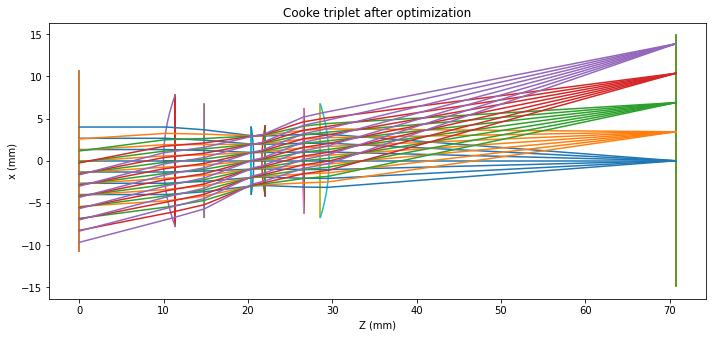

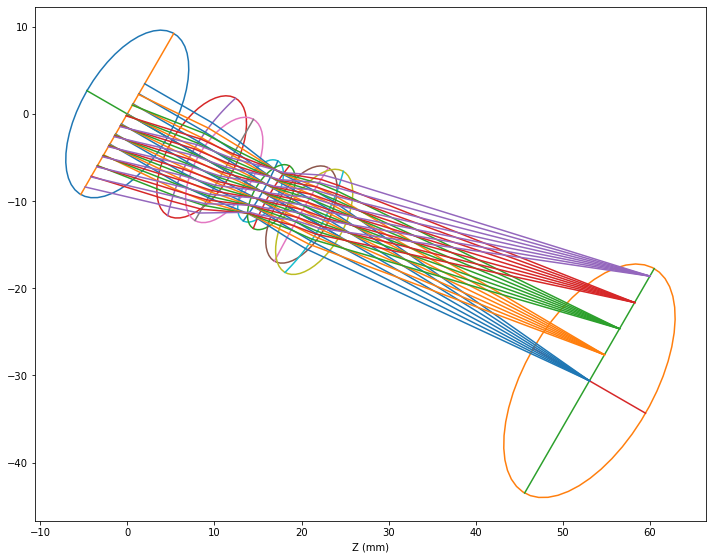

In [12]:
apply_draw_radii(opt_geometry, ray_table, 1)
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, opt_geometry)
rtd.plot_rays(axd, opt_geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet after optimization")
plt.show()
axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, opt_geometry)
rtd.plot_rays(axd, opt_geometry, ray_table, color_by = "field")

In [13]:
merit_after = merit(result['x'])
'''
The merit function is the square of the RMS, so we take a square
root in order to get the RMS spot size'''

np.sqrt(merit_before), np.sqrt(merit_after)

(0.012655048546162923, 0.002357493950548987)

In [29]:
'''
Setting up a lengthy trace
'''
def lengthy():
    t0 = time.time()
    geometry = rtt.build_geometry(surface_list)
    print('build_geometry', time.time() - t0)

    # Lists of field anles, pupil heights, and (for now) zero pupil shifts

    field_angles = np.linspace(0, 15, 500)
    pupil_radii = np.linspace(-4, 4, 500)

    # turn those lists into rays

    field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in field_angles])
    pupil_points = np.array([np.array([x, 0, 0]) for x in pupil_radii])
    wavls = np.array([0.000633])

    # my usual ray tracing steps
    t0 = time.time()
    ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True)
    print('new_ray_table', time.time() - t0)
    t0 = time.time()
    rtt.trace_rays(ray_table, geometry)
    print('trace_rays', time.time() - t0)
    return geometry
    
geometry = lengthy()

build_geometry 0.016299009323120117
new_ray_table 1.7416002750396729


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'intersect_line_plane':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "..\src\opticsRayTrace\rayTraceTools_numba.py", line 389:[0m
[1mdef compute_sags_conic_surface(ray_table, surf, origin, z_axis, c, k, r, sag):
    <source elided>
        for iter in range(40):
[1m            ray_table[surf, j, 0, :] = intersect_line_plane(
[0m            [1m^[0m[0m
[0m

In [16]:
for surf in geometry:
    if 'times' in surf:
        print(surf['surf'], surf['times'])

conic [0.684009313583374, 0.19761371612548828]
conic [0.2973926067352295, 0.30184340476989746]
conic [0.726712703704834, 0.17139601707458496]
conic [0.516160249710083, 0.1680457592010498]
conic [0.501089334487915, 0.1990206241607666]
conic [0.7640087604522705, 0.17783617973327637]
dummy []


In [27]:
for surf in geometry:
    if 'times' in surf:
        print(surf['surf'], surf['times'])

conic [0.9700756072998047, 0.1411268711090088]
conic [0.3163909912109375, 0.13152170181274414]
conic [0.47008681297302246, 0.13161277770996094]
conic [0.45348381996154785, 0.14805388450622559]
conic [0.457080602645874, 0.1299135684967041]
conic [0.78568434715271, 0.16729068756103516]
dummy []


In [87]:
print(rtt.sag_conic_sp)
print(rtt.sag_conic_diff_sp)

c*r**2/(sqrt(-c**2*r**2*(k + 1) + 1) + 1)
c*(c**2*r**2*(k + 1) + 2*sqrt(-c**2*r**2*(k + 1) + 1)*(sqrt(-c**2*r**2*(k + 1) + 1) + 1))/(sqrt(-c**2*r**2*(k + 1) + 1)*(sqrt(-c**2*r**2*(k + 1) + 1) + 1)**2)
